<h1>GMM improvement algorithm</h1>

In [392]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import permutations
from itertools import combinations

In [ ]:
data = pd.read_csv('activities.csv')
print(data.columns)

#Elapsed time
#Moving time
#Distance
#Activity Type
#Max heart rate
#Relative effort
#Average Heart Rate
#Elevation Gain
#Average Positive Grade
#Activity Date


df = data[['Activity Type', 'Moving Time', 'Elapsed Time', 'Distance', 'Elevation Gain','Activity time', 'Max Speed', 'Average Speed']]#, 'Max Heart Rate', 'Average Heart Rate']]
# print(df)
dfhr = df.iloc[119:][df['Activity Type'] == 'Run']
dfhr = df.iloc[1:][df['Activity Type'] == 'Run']
print(data['Relative Effort'])
dfhr = dfhr.dropna()

Index(['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type',
       'Activity Description', 'Elapsed Time', 'Distance', 'Max Heart Rate',
       'Relative Effort', 'Commute', 'Activity Private Note', 'Activity Gear',
       'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1',
       'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed',
       'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High',
       'Max Grade', 'Average Grade', 'Average Positive Grade',
       'Average Negative Grade', 'Max Cadence', 'Average Cadence',
       'Max Heart Rate.1', 'Average Heart Rate', 'Max Watts', 'Average Watts',
       'Calories', 'Max Temperature', 'Average Temperature',
       'Relative Effort.1', 'Total Work', 'Number of Runs', 'Uphill Time',
       'Downhill Time', 'Other Time', 'Perceived Exertion', 'Type',
       'Start Time', 'Weighted Average Power', 'Power Count',
       'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1',
    

C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\3004262555.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfhr = df.iloc[119:][df['Activity Type'] == 'Run']
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\3004262555.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfhr = df.iloc[1:][df['Activity Type'] == 'Run']


In [ ]:
dfhrc = dfhr.drop(columns=['Activity Type', 'Activity time'])
dfhrc['Distance'] = dfhrc['Distance'].astype('float')
dfhrc = dfhrc[['Moving Time', 'Distance', 'Elevation Gain', 'Average Speed']]#, 'Average Heart Rate']]
times = dfhr['Activity Date']
speed = dfhr['Average Speed']
tim = dfhr['Elapsed Time']
# dfhrc = dfhrc[['Moving Time', 'Elapsed Time', 'Relative Effort']]
print(dfhrc)

     Moving Time  Distance  Elevation Gain  Average Speed
3         1959.0      5.36       17.831402       2.736100
4         1099.0      3.24       11.702381       2.954823
5          846.0      2.61        8.268750       3.087175
7         1116.0      3.22       14.260119       2.893100
8          509.0      1.61       11.286633       3.164754
..           ...       ...             ...            ...
211       1804.0      5.11       30.000000       2.836253
213       1525.0      3.72       27.000000       2.439869
215       2434.0      6.49       40.000000       2.666516
216       1872.0      5.03       26.000000       2.691400
217       1808.0      5.02       28.000000       2.777876

[124 rows x 4 columns]


In [395]:
def pdf(x, m, cov):
    xm = x - m
    frac = 1/(((2*np.pi)**2)*np.linalg.det(cov))**.5
    exp = np.exp(-.5*np.dot(xm.T, np.dot(np.linalg.inv(cov), xm)))
    return exp * frac
    #np.exp(-.5*(np.dot(xm.T, np.dot(np.linalg.inv(cov), xm))))/(2*np.pi*np.sqrt(np.linalg.det(cov)))

In [396]:
def GMM(dat, k, tol):
    ##
    dat = dat.to_numpy()
    r= dat.shape[0]
    p_class = np.ones(k)/k
    covars = np.array([np.eye(2) for i in range(k)])
    means = dat[np.random.choice(r, k, replace=False)]
    oldMeans = np.copy(means)
    meanDiff = 100000000000
    
    while(meanDiff > tol):
        #expectations step
        resp = np.zeros((r, k))
        for a in range(r):
            for b in range(k):
                resp[a, b] = pdf(dat[a], means[b], covars[b])*p_class[b]
                print(pdf(dat[a], means[b], covars[b]))
            resp[a, :] /= resp[a, :].sum()  
        #Maximize step
        for c in range(k):
            weight = np.sum(resp[:, c])
            means[c] = np.sum(resp[:, c, None] * dat, axis=0) / weight
            covars[c] = (resp[:, c, None, None] * np.einsum('ni,nj->nij', dat - means[c], dat - means[c])).sum(axis=0) / weight
            p_class[c] = weight / r
        meanDiff = np.linalg.norm(means - oldMeans)
        oldMeans = np.copy(means)
    return resp, means, covars, p_class, meanDiff

In [397]:
def stable_pdf(x, mean, cov):
    d = len(x)
    cov_reg = cov + 1e-6 * np.eye(d)  # regularization
    try:
        cov_det = np.linalg.det(cov_reg)
        cov_inv = np.linalg.inv(cov_reg)
    except np.linalg.LinAlgError:
        return 1e-300

    if cov_det <= 0 or np.isnan(cov_det):
        return 1e-300

    norm_const = 1.0 / (np.sqrt((2 * np.pi) ** d * cov_det))
    diff = x - mean
    exponent = -0.5 * diff.T @ cov_inv @ diff
    return max(norm_const * np.exp(exponent), 1e-300)

def GMM(dat, k, tol=1e-4, max_iter=1000000000):
    # Normalize the data
    scaler = StandardScaler()
    dat = scaler.fit_transform(dat)

    r, d = dat.shape
    p_class = np.ones(k) / k
    covars = np.array([np.eye(d) for _ in range(k)])
    means = dat[np.random.choice(r, k, replace=False)]
    oldMeans = np.copy(means)
    meanDiff = np.inf

    for iteration in range(max_iter):
        if meanDiff <= tol:
            break

        # E-step: compute responsibilities
        resp = np.zeros((r, k))
        for a in range(r):
            for b in range(k):
                resp[a, b] = stable_pdf(dat[a], means[b], covars[b]) * p_class[b]
            denom = resp[a, :].sum()
            resp[a, :] /= denom if denom > 1e-12 else 1e-12

        # M-step: update parameters
        for c in range(k):
            weight = np.sum(resp[:, c])
            means[c] = np.sum(resp[:, c, None] * dat, axis=0) / weight
            diff = dat - means[c]
            covars[c] = (resp[:, c, None, None] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / weight
            covars[c] += 1e-6 * np.eye(d)  # regularize covariance
            p_class[c] = weight / r

        meanDiff = np.linalg.norm(means - oldMeans)
        oldMeans = np.copy(means)

    return resp, means, covars, p_class

In [398]:
resp, means, covars, p_class =GMM(dfhrc, 5, .000000015)
print(dfhrc.columns)

Index(['Moving Time', 'Distance', 'Elevation Gain', 'Average Speed'], dtype='object')


In [399]:
def compute_log_likelihood(X, means, covars, p_class):
    r, k = X.shape[0], len(means)
    ll = 0
    for i in range(r):
        prob = 0
        for j in range(k):
            prob += p_class[j] * pdf(X[i], means[j], covars[j])
        ll += np.log(prob + 1e-10)  # avoid log(0)
    return ll

In [400]:
performance = ( .5*dfhr['Average Speed'] + .3*dfhrc['Distance'] / dfhr['Elapsed Time'] + .2*dfhr['Elevation Gain'])

In [446]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_gmm(date_series, avg_speed_series, cluster_ids):
    df = pd.DataFrame({
        'date': pd.to_datetime(date_series),
        'speed': avg_speed_series,
        'cluster': cluster_ids
    })

    df = df.sort_values(by='date')
    df['date_ordinal'] = df['date'].map(pd.Timestamp.toordinal)

    # Set up the plot
    plt.figure(figsize=(12, 6))

    unique_clusters = sorted(df['cluster'].unique())
    colors = plt.cm.tab10.colors  # max 10 colors — can be expanded if needed

    for i, cluster in enumerate(unique_clusters):
        sub_df = df[df['cluster'] == cluster]

        # Scatter plot for this cluster
        plt.scatter(sub_df['date'], sub_df['speed'],
                    color=colors[i % len(colors)],
                    alpha=0.6,
                    label=f"Cluster {cluster}")

        # Line of best fit for this cluster
        x = sub_df['date_ordinal'].values
        y = sub_df['speed'].values
        if len(x) > 1:
            coeffs = np.polyfit(x, y, deg=1)
            trend = np.poly1d(coeffs)
            plt.plot(sub_df['date'], trend(x),
                     color=colors[i % len(colors)],
                     linestyle='--',
                     label=f"Trend {cluster}")

    plt.xlabel("Date")
    plt.ylabel("Average Speed")
    plt.title("All Clusters: Avg Speed Over Time with Trend Lines")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)


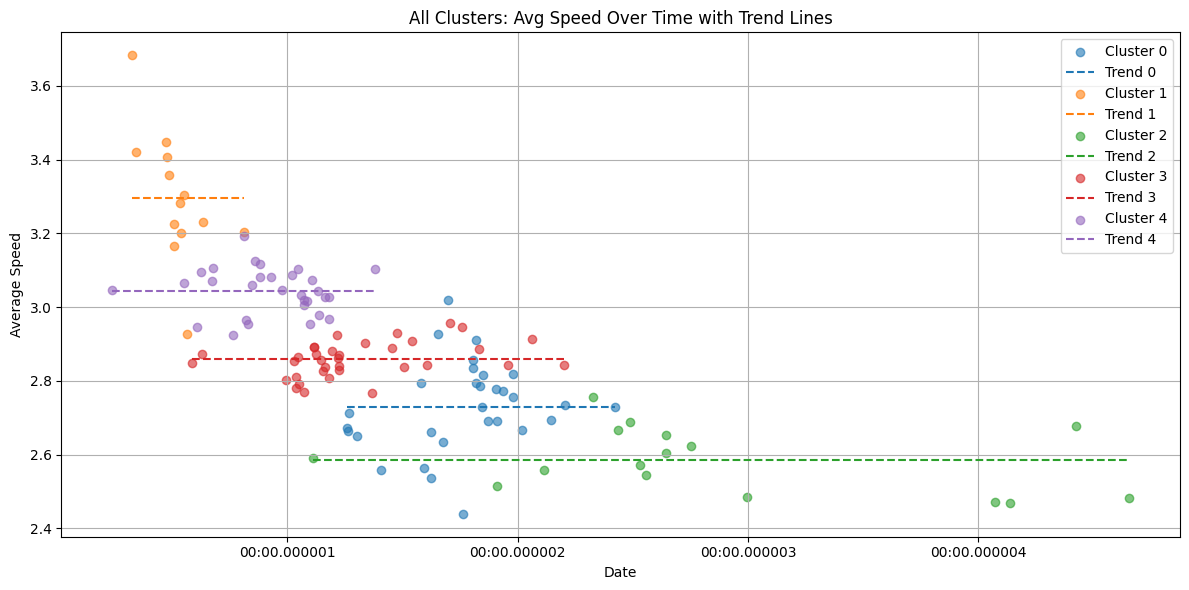

In [447]:
plot_gmm(dfhr['Elapsed Time'], dfhrc['Average Speed'], np.argmax(resp, axis=1))

C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)


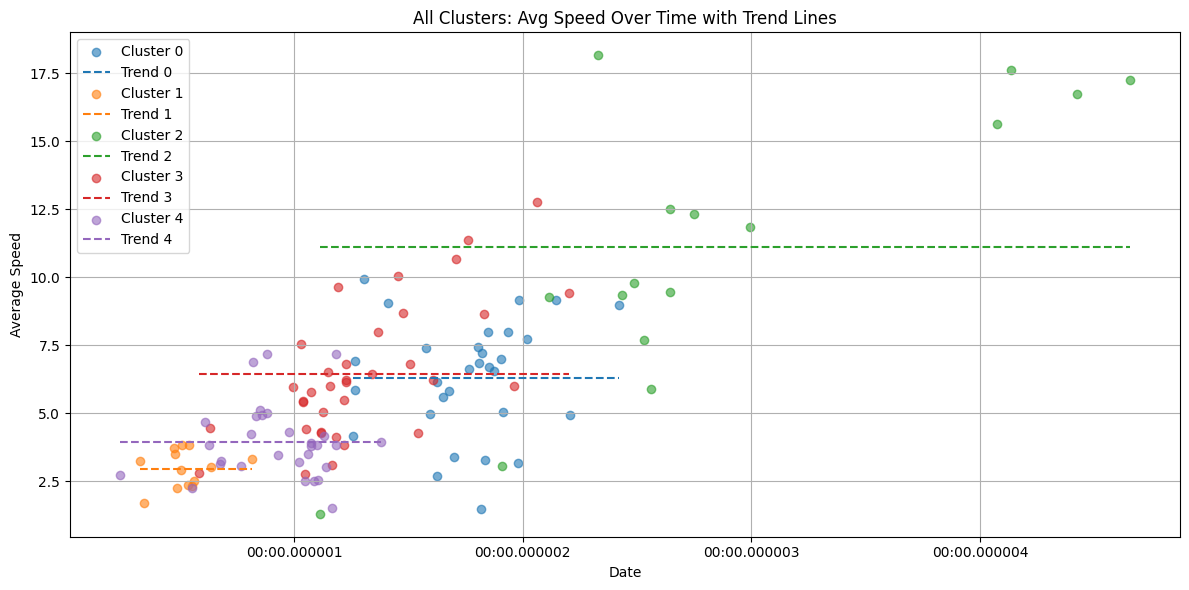

In [453]:
plot_gmm(dfhr['Elapsed Time'], performance, np.argmax(resp, axis=1))

C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)
C:\Users\notu5424\AppData\Local\Temp\ipykernel_17824\2815158627.py:34: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1)


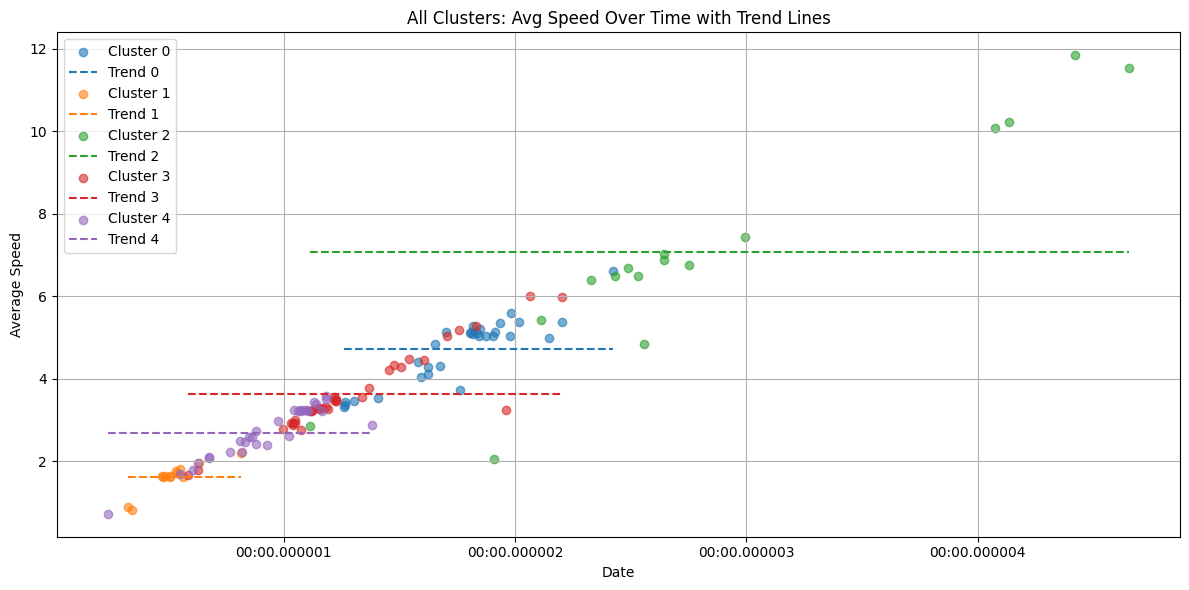

In [455]:
plot_gmm(dfhr['Elapsed Time'], dfhrc['Distance'], np.argmax(resp, axis=1))

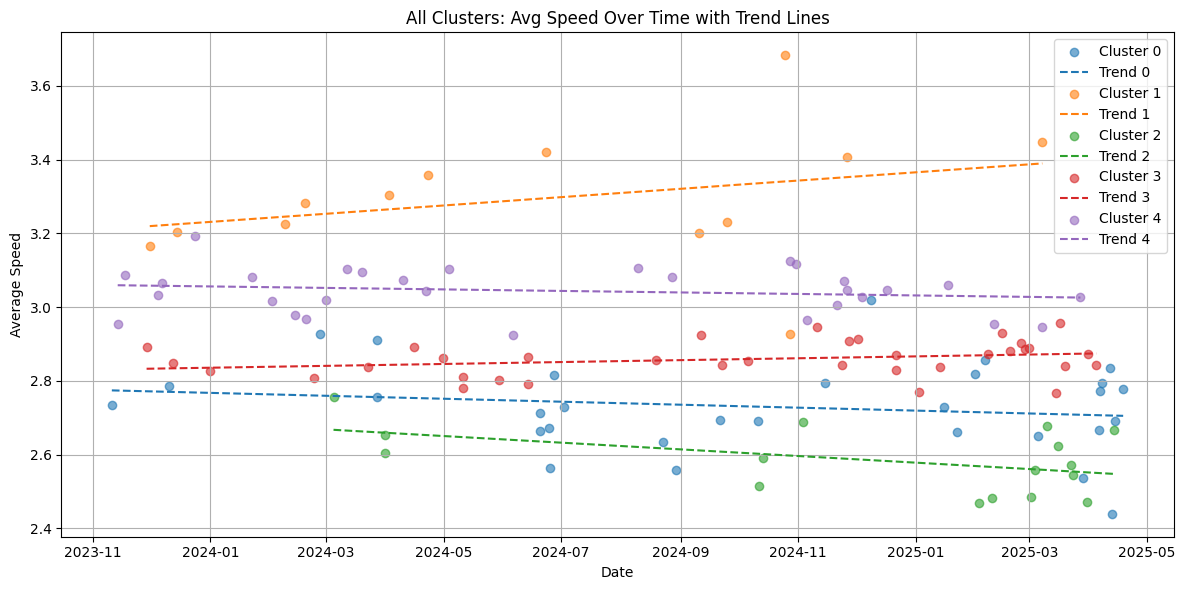

In [457]:
plot_gmm(dfhr['Activity Date'], dfhrc['Average Speed'], np.argmax(resp, axis=1))

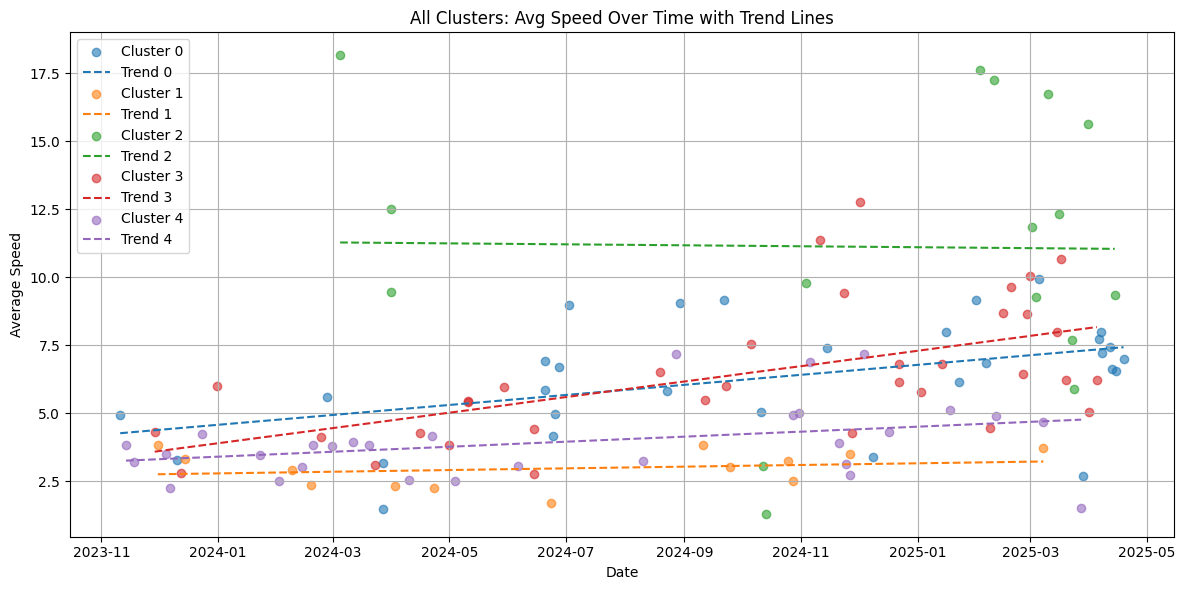

In [458]:
plot_gmm(dfhr['Activity Date'], performance, np.argmax(resp, axis=1))

In [459]:
def plot_cluster_scatter_with_trend(date_series, avg_speed_series, cluster_ids):
    df = pd.DataFrame({
        'date': pd.to_datetime(date_series),
        'speed': avg_speed_series,
        'cluster': cluster_ids
    })

    df = df.sort_values(by='date')
    df['date_ordinal'] = df['date'].map(pd.Timestamp.toordinal)

    unique_clusters = sorted(df['cluster'].unique())
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(10, 4 * len(unique_clusters)), sharex=True)

    if len(unique_clusters) == 1:
        axes = [axes]  # edge case if there's only one cluster

    for i, cluster in enumerate(unique_clusters):
        sub_df = df[df['cluster'] == cluster]
        ax = axes[i]
        ax.scatter(sub_df['date'], sub_df['speed'], alpha=0.6, label=f"Cluster {cluster}")

        # Fit a line using linear regression on the date ordinals
        x = sub_df['date_ordinal'].values
        y = sub_df['speed'].values
        if len(x) > 1:
            coeffs = np.polyfit(x, y, deg=1)
            trend = np.poly1d(coeffs)
            ax.plot(sub_df['date'], trend(x), color='red', linestyle='--', label='Trend Line')

        ax.set_title(f"Cluster {cluster}: Average Speed Over Time")
        ax.set_ylabel("Avg Speed")
        ax.legend()
        ax.grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


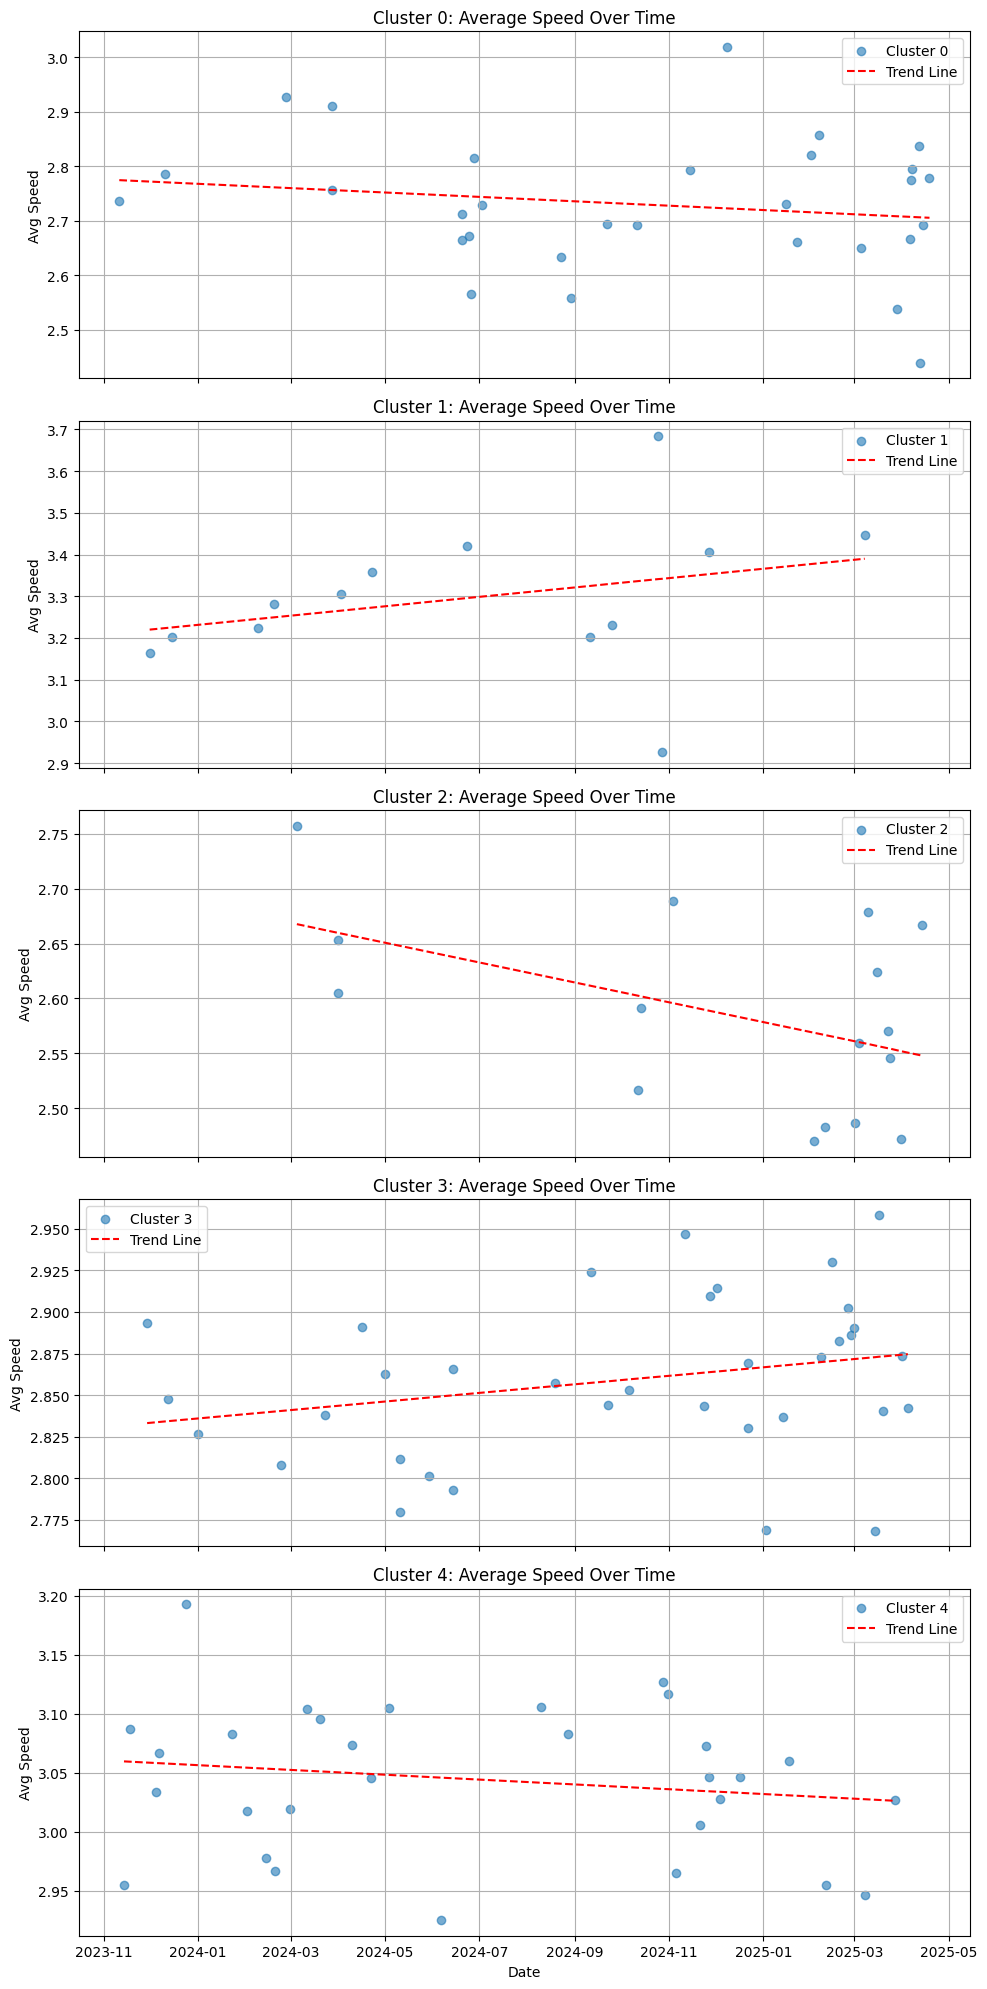

In [460]:
plot_cluster_scatter_with_trend(dfhr['Activity Date'], dfhrc['Average Speed'],  np.argmax(resp, axis=1))

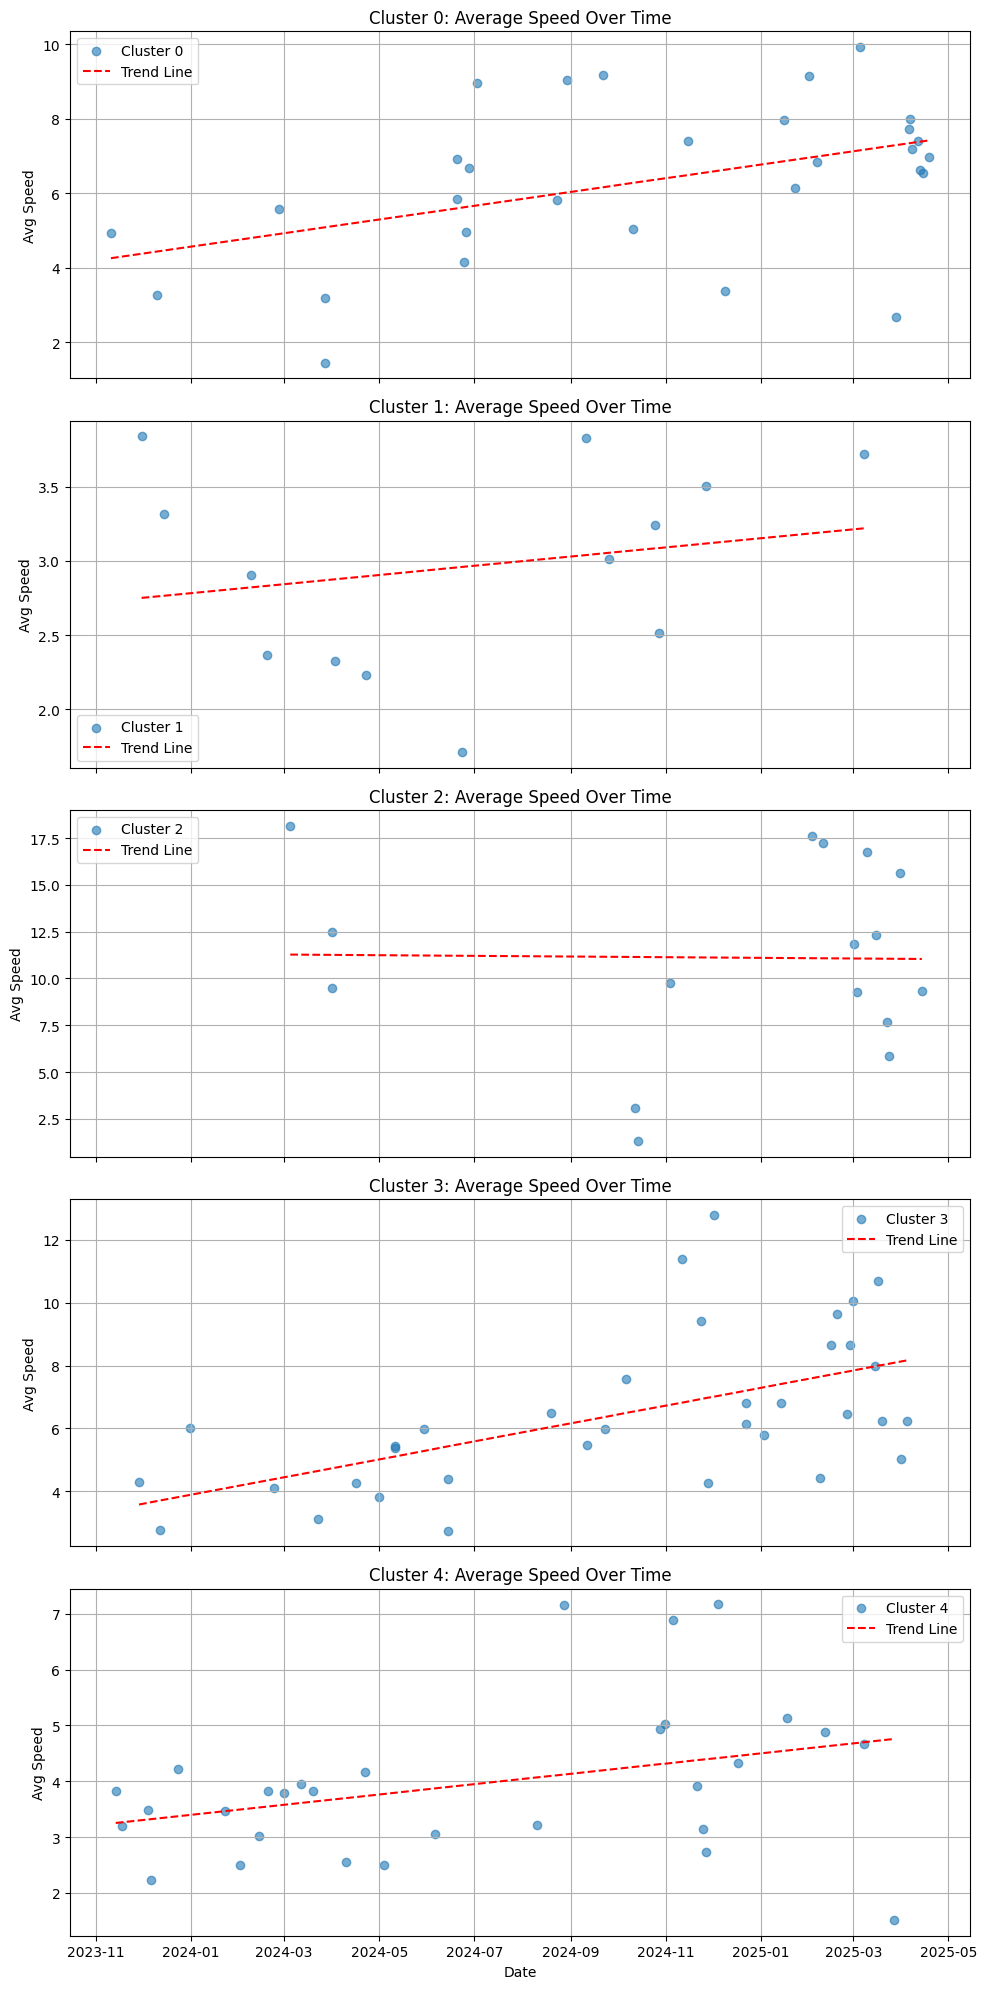

In [461]:
plot_cluster_scatter_with_trend(dfhr['Activity Date'], performance,  np.argmax(resp, axis=1))